In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.init import kaiming_uniform_#
from matplotlib import pyplot as plt


In [2]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count
from torch.distributions import Categorical
torch.manual_seed(0)

In [3]:
env = gym.make("CartPole-v0")

In [4]:
class linearApproximator_FCDAP(nn.Module):
    def __init__(self,state_shape,outputs,hidden_dims=(32,32)):
        super(linearApproximator_FCDAP, self).__init__()
        self.input_size = state_shape
        self.out = outputs
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                   else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(\
                                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer  = nn.Linear(hidden_dims[-1],self.out)
        self.to(self.device)
        
        
        
    def forward(self, state_shape):
        if not isinstance(state_shape, torch.Tensor):
            state_shape = torch.tensor(state_shape, dtype=torch.float32)
        state_shape = state_shape.to(self.device)
            
        x = self.fc1(state_shape)
        x = F.relu(x)
        
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        
        logits = self.output_layer(x)#logits, preferences of actions
        return logits
        
    def full_pass(self, state):
        logits = self.forward(state).cpu()
        distribution = Categorical(logits=logits)
        action = distribution.sample()#sample action
        log_prob_action = distribution.log_prob(action).unsqueeze(-1)#gets prob of sampled action
        entropy = distribution.entropy().unsqueeze(-1)
        return action.item(), log_prob_action, entropy, logits

In [5]:
def select_action(model, state):
    action, log_prob_action, entropy, logits = model.full_pass(state)
    return action, log_prob_action

In [6]:
def select_greedy_actions(model,state):
    _,_,_,logits_ = model(state)
    print("g_actions: ", logits_.shape)
    return np.argmax(logits_.detach.numpy())

In [7]:
def numpy_to_tensor(val):
    device = device = torch.device("cuda" if torch.cuda.is_available()\
                                   else "cpu")
    return torch.tensor(val)

In [8]:
def optimize_model(reward_store, log_pa,model,gamma,optimizer):
    Trajectory_length = len(reward_store)
    
    discounts = np.logspace(0,Trajectory_length,\
                           num=Trajectory_length,base=gamma,\
                           endpoint=False)
    
    returns = np.array([np.sum(discounts[:Trajectory_length-t] * reward_store[t:]) for t in range(Trajectory_length)])
    
    discounts_tensor = torch.tensor(discounts).unsqueeze(1)
    returns = torch.tensor(returns).unsqueeze(1)
    log_pa = torch.stack(log_pa)
    policy_loss = -(discounts_tensor*returns*log_pa).mean()
    #print(policy_loss)
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

In [9]:
from collections import namedtuple
Xp = namedtuple('Experience',
                        ('reward', 'log_prob_action'))
Xp_points = Xp(5,6)
Xp_points

Experience(reward=5, log_prob_action=6)

In [17]:
observation_space = len(env.reset())
action_space = env.action_space.n
model = linearApproximator_FCDAP(observation_space,\
                                     action_space,hidden_dims=(128,64))

In [18]:
model

linearApproximator_FCDAP(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [22]:
def REINFORCE_(env,
               model,
              n_ep=20000,
              gamma=0.99
              ):
    
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    ovr_rewards = []
    for e in tqdm(range(n_ep)):
        state = env.reset()
        acc_rewards = 0
        
        reward_store = []
        log_pa = [] 
        
        while True:
            action, log_prob = select_action(model, state)
            next_state, reward, done, info = env.step(action)
            state = next_state
            acc_rewards+=reward
            reward_store.append(reward)
            log_pa.append(log_prob)
            if done==True:
                break
        
        optimize_model(reward_store, log_pa, model, gamma, optimizer)
        plot_grad_flow(model.named_parameters())
        ovr_rewards.append(acc_rewards)
    return ovr_rewards,model

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [37:06<00:00,  8.98it/s]


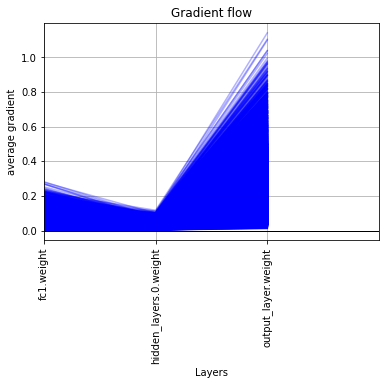

In [23]:
ovr_rewards,model = REINFORCE_(env, model)

In [26]:
from scipy.ndimage.filters import uniform_filter1d
arr = uniform_filter1d(ovr_rewards, size=5)

In [27]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

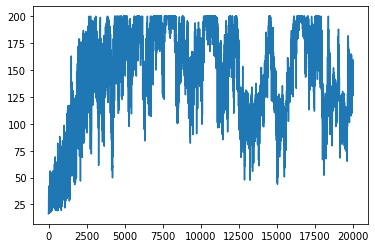

In [28]:
plt.plot(y, x)#tau 0.1, t = 10 0.01 decay, corrected, added min_sample sixe and batch_size